## Æther: Pipeline


In [1]:
import os
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

## Dataset


In [2]:
class PlagiarismDataset(Dataset):
    """
    PyTorch Dataset implementation for code plagiarism detection

    This class handles pairs of code files, reading them from specific
    directories, tokenizing them together, and preparing them for model input.

    Attributes:
        file_pairs (list): List of tuples containing pairs of files IDS (id1, id2)
        labels (list): List of binary labels (0 for no plagiarism, 1 for plagiarism)
        base_dir (Path): Base directory containing the code files
        tokenizer: HuggingFace tokenizer for encoding code pairs
        max_length (int): Maximum sequence length for tokenization
    """

    def __init__(self, file_pairs, labels, base_dir, tokenizer, max_length=512):
        """
        Initialize the plagiarism dataset.

        Args:
            file_pairs (list): List of tuples containing pairs of file IDs to compare
            labels (list): Corresponding binary labels (0/1) indicating plagiarism
            base_dir (str or Path): Root directory containing the code files
            tokenizer: HuggingFace tokenizer for encoding the code
            max_length (int, optional): Maximum sequence length for tokenization. Defaults to 512.
        """

        self.file_pairs = file_pairs
        self.labels = labels
        self.base_dir = Path(base_dir)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Get the number of code pairs in the dataset.

        Returns:
            int: Number of code pairs
        """

        return len(self.file_pairs)

    def __getitem__(self, idx):
        """
        Get a code pair and its label by index.

        This method:
        1. Retrieves file IDs and label for the specified index
        2. Reads code content from both files
        3. Tokenizes both code samples together
        4. Returns a dictionary with tokenized inputs and label

        Args:
            idx (int): Index of the code pair to retrieve

        Returns:
            dict: Dictionary containing:
                - 'input_ids': Tokenized input IDs
                - 'attention_mask': Attention mask for the tokenized input
                - 'label': Tensor containing the plagiarism label
        """

        id1, id2 = self.file_pairs[idx]
        label = self.labels[idx]

        code1 = self._read_file(id1)
        code2 = self._read_file(id2)

        encoded = self.tokenizer(
            code1,
            code2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.float),
        }

    def _read_file(self, file_id):
        """
        Read a Java code file from the dataset directory.

        The files are identified by their ID and all have .java extension.
        The CSV file contains pairs of IDs indicating which files to compare.

        Args:
            file_id: ID of the Java file to read

        Returns:
            str: Content of the Java code file or empty string if file not found
        """

        path = self.base_dir / f"{file_id}.java"
        if path.exists():
            try:
                return path.read_text(encoding="utf-8")

            except UnicodeDecodeError:
                return path.read_text(encoding="latin-1")

## Model


In [3]:
class PlagiarismModel(nn.Module):
    """
    Neural network model for code plagiarism detection based on CodeBERT embeddings.

    This model utilizes CodeBERT to extract contextual embeddings from pairs of
    code samples, then passes the CLS token representation through a classifier
    network to predict whether the code pair exhibits plagiarism.

    Attributes:
        codebert: Pretrained CodeBERT model for extracting code embeddings
        classifier: Sequential neural network for binary classification
    """

    def __init__(self, model_name):
        """
        Initialize the plagiarism detection model.

        Args:
            model_name (str): Name or path of the pretrained CodeBERT model
                              (e.g., "huggingface/CodeBERTa-small-v1")

        Note:
            The model assumes CodeBERT's hidden size is 768 dimensions. If using
            a different pretrained model, this value may need adjustment.
        """

        super(PlagiarismModel, self).__init__()

        self.codebert = AutoModel.from_pretrained(model_name)
        for param in list(self.codebert.parameters())[:-2]:
            param.requires_grad = False

        self.attention = nn.Sequential(
            nn.Linear(768, 128), nn.Tanh(), nn.Linear(128, 1), nn.Softmax(dim=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(768, 384),
            nn.LayerNorm(384),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.LayerNorm(192),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(192, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.

        The model processes tokenized code pairs through CodeBERT, extracts the
        CLS token representation (which encodes the relationship between the two
        code samples), and passes it through the classifier to get plagiarism
        prediction logits.

        Args:
            input_ids (torch.Tensor): Tokenized input IDs of code pairs
            attention_mask (torch.Tensor): Attention mask for the input

        Returns:
            torch.Tensor: Logits for binary classification (no plagiarism, plagiarism)
        """

        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)

        # Apply attention to the sequence
        sequence_output = outputs.last_hidden_state
        attention_weights = self.attention(sequence_output)
        context_vector = torch.sum(attention_weights * sequence_output, dim=1)

        # Classification with the contextualized representation
        return self.classifier(context_vector).squeeze()

## Detection


In [4]:
class PlagiarismDetection:
    """
    Main class for code plagiarism detection that orchestrates the entire workflow.

    This class handles the complete plagiarism detection pipeline including:
    - Model initialization and configuration
    - Data loading and preprocessing
    - Model training and evaluation
    - Model saving and loading

    Attributes:
        model_name (str): Name or path of the CodeBERT model
        tokenizer: HuggingFace tokenizer for encoding code pairs
        model: The neural network model for plagiarism detection
        device: PyTorch device for computation (CPU or GPU)
    """

    def __init__(self, model_name="huggingface/CodeBERTa-small-v1"):
        """
        Initialize the plagiarism detection system.

        Args:
            model_name (str, optional): Pretrained model identifier to use.
                                       Defaults to "microsoft/codebert-base".
        """

        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = PlagiarismModel(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def load_data(self, csv_path, data_dir):
        """
        Load and prepare data for training and testing.

        Reads the CSV file containing code pair IDs and plagiarism labels,
        splits the data into training and test sets, and creates DataLoader
        instances for efficient batch processing.

        Args:
            csv_path (str): Path to the CSV file with columns 'id1', 'id2', 'plagio'
            data_dir (str): Directory containing code files

        Returns:
            tuple: (train_loader, val_loader, test_loader) - DataLoader instances for training and testing
        """

        df = pd.read_csv(csv_path)

        required_columns = ["id1", "id2", "plagio"]
        missing_columns = [col for col in required_columns if col not in df.columns]

        if missing_columns:
            raise ValueError(
                f"CSV file missing required columns: {missing_columns}. Available columns: {df.columns.tolist()}"
            )

        file_pairs = list(zip(df["id1"], df["id2"]))
        labels = df["plagio"].tolist()

        # Print class distribution to understand imbalance
        class_counts = pd.Series(labels).value_counts()
        print(f"Class distribution in dataset: {dict(class_counts)}")

        # Calculate class weights for loss function
        class_weights = {
            0: 1.0,
            1: (
                class_counts[0] / class_counts[1]
                if 1 in class_counts and class_counts[1] > 0
                else 10.0
            ),
        }
        self.class_weights = torch.FloatTensor([class_weights[0], class_weights[1]]).to(
            self.device
        )
        print(f"Using class weights: {class_weights}")

        train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
            file_pairs, labels, test_size=0.3, random_state=42, stratify=labels
        )

        val_pairs, test_pairs, val_labels, test_labels = train_test_split(
            temp_pairs,
            temp_labels,
            test_size=0.67,
            random_state=42,
            stratify=temp_labels,
        )

        train_dataset = PlagiarismDataset(
            train_pairs, train_labels, data_dir, self.tokenizer
        )

        val_dataset = PlagiarismDataset(val_pairs, val_labels, data_dir, self.tokenizer)

        test_dataset = PlagiarismDataset(
            test_pairs, test_labels, data_dir, self.tokenizer
        )

        # Using weighted sampler for the training set to handle class imbalance
        train_labels_array = np.array(train_labels)
        class_sample_count = np.array(
            [
                len(np.where(train_labels_array == t)[0])
                for t in np.unique(train_labels_array)
            ]
        )
        weight = 1.0 / class_sample_count
        samples_weight = np.array([weight[t] for t in train_labels_array])
        samples_weight = torch.from_numpy(samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(
            samples_weight.type("torch.DoubleTensor"), len(samples_weight)
        )

        train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=16)
        test_loader = DataLoader(test_dataset, batch_size=16)

        return train_loader, val_loader, test_loader

    def train(self, train_loader, val_loader=None, epochs=3):
        """
        Train the plagiarism detection model.

        Performs training for the specified number of epochs, tracking
        loss and accuracy metrics throughout the process.

        Args:
            train_loader (DataLoader): DataLoader containing training data
            val_loader (DataLoader, optional): DataLoader containing validation data
            epochs (int, optional): Number of training epochs. Defaults to 3.
        """

        self.history = {
            "train_loss": [],
            "train_acc": [],
            "train_f1": [],
            "val_loss": [],
            "val_acc": [],
            "val_f1": [],
        }

        # Using different learning rates for different parts of the model
        optimizer = torch.optim.AdamW(
            [
                {
                    "params": self.model.codebert.parameters(),
                    "lr": 5e-6,
                },  # Lower learning rate for pretrained model
                {
                    "params": self.model.classifier.parameters(),
                    "lr": 2e-4,
                },  # Higher learning rate for classifier
            ]
        )

        # Use weighted BCE loss to handle class imbalance
        criterion = nn.BCELoss()

        # Early stopping parameters
        best_val_f1 = 0
        patience = 3
        no_improve_epochs = 0
        best_model_state = None

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            total_loss = 0
            all_labels = []
            all_preds = []

            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)

                # Forward pass
                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)

                # Apply focal loss properties within BCE
                pt = torch.where(labels == 1, outputs, 1 - outputs)
                focal_weight = (1 - pt) ** 2  # gamma=2

                # Apply class weights to the loss
                weights = torch.where(
                    labels == 1, self.class_weights[1], self.class_weights[0]
                )

                # Combine focal and class weights
                sample_weights = weights * focal_weight

                # Calculate weighted loss manually
                bce_loss = -(
                    labels * torch.log(outputs + 1e-7)
                    + (1 - labels) * torch.log(1 - outputs + 1e-7)
                )
                loss = (bce_loss * sample_weights).mean()

                # Backward pass
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                # Track metrics
                total_loss += loss.item()
                predicted = (outputs > 0.5).float()  # Binary threshold at 0.5

                # Collect for F1 calculation
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

            # Calculate epoch metrics
            from sklearn.metrics import f1_score, accuracy_score

            epoch_loss = total_loss / len(train_loader)
            epoch_acc = accuracy_score(all_labels, all_preds) * 100
            epoch_f1 = f1_score(all_labels, all_preds, average="binary") * 100

            print(
                f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%, F1={epoch_f1:.2f}%"
            )

            self.history["train_loss"].append(epoch_loss)
            self.history["train_acc"].append(epoch_acc)
            self.history["train_f1"].append(epoch_f1)

            # Validation phase
            if val_loader is not None:
                val_loss, val_acc, val_f1 = self._evaluate_epoch(val_loader, criterion)
                print(
                    f"Validation: Loss={val_loss:.4f}, Accuracy={val_acc:.2f}%, F1={val_f1:.2f}%"
                )

                self.history["val_loss"].append(val_loss)
                self.history["val_acc"].append(val_acc)
                self.history["val_f1"].append(val_f1)

                # Early stopping based on F1 score
                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    no_improve_epochs = 0
                    best_model_state = {
                        k: v.cpu().clone() for k, v in self.model.state_dict().items()
                    }
                else:
                    no_improve_epochs += 1
                    if no_improve_epochs >= patience:
                        print(f"Early stopping triggered after {epoch+1} epochs")
                        break

        # Restore best model if we did early stopping
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        self.plot_history()

    def _evaluate_epoch(self, data_loader, criterion):
        """
        Evaluate model performance for a single epoch.

        Args:
            data_loader (DataLoader): DataLoader to evaluate on
            criterion: Loss function

        Returns:
            tuple: (loss, accuracy, f1_score) for the epoch
        """

        self.model.eval()
        total_loss = 0
        all_labels = []
        all_preds = []
        all_probs = []  # Store probabilities for ROC curve

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                predicted = (outputs > 0.5).float()  # Binary threshold at 0.5

                # Collect for metrics calculation
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())

        # Calculate metrics using sklearn for better handling of edge cases
        from sklearn.metrics import f1_score, accuracy_score

        epoch_loss = total_loss / len(data_loader)
        epoch_acc = accuracy_score(all_labels, all_preds) * 100
        epoch_f1 = (
            f1_score(all_labels, all_preds, average="binary", zero_division=0) * 100
        )

        # Set back to training mode
        self.model.train()

        return epoch_loss, epoch_acc, epoch_f1

    def plot_history(self):
        """
        Plot training and validation history including F1 score.
        """

        plt.figure(figsize=(15, 5))

        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(self.history["train_loss"], label="Training Loss")
        if len(self.history["val_loss"]) > 0:
            plt.plot(self.history["val_loss"], label="Validation Loss")
        plt.title("Loss during Training")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 3, 2)
        plt.plot(self.history["train_acc"], label="Training Accuracy")
        if len(self.history["val_acc"]) > 0:
            plt.plot(self.history["val_acc"], label="Validation Accuracy")
        plt.title("Accuracy during Training")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        # Plot F1 score
        plt.subplot(1, 3, 3)
        plt.plot(self.history["train_f1"], label="Training F1")
        if len(self.history["val_f1"]) > 0:
            plt.plot(self.history["val_f1"], label="Validation F1")
        plt.title("F1 Score during Training")
        plt.xlabel("Epoch")
        plt.ylabel("F1 Score (%)")
        plt.legend()

        plt.tight_layout()
        plt.savefig("training_history.png")
        plt.show()

    def evaluate(self, test_loader):
        """
        Evaluate the model on test data.

        Sets the model to evaluation mode and calculates accuracy on the test set.
        Also generates a confusion matrix and performance graphs.

        Args:
            test_loader (DataLoader): DataLoader containing test data

        Returns:
            float: F1 score percentage on test data
        """

        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Testing"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                predicted = (outputs > 0.5).float()  # Binary threshold at 0.5

                # Collect predictions and labels for metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())

        # Calculate comprehensive metrics
        from sklearn.metrics import (
            accuracy_score,
            f1_score,
            precision_score,
            recall_score,
            roc_auc_score,
            roc_curve,
        )

        accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds, average="binary", zero_division=0) * 100
        precision = (
            precision_score(all_labels, all_preds, average="binary", zero_division=0)
            * 100
        )
        recall = (
            recall_score(all_labels, all_preds, average="binary", zero_division=0) * 100
        )

        try:
            auc = roc_auc_score(all_labels, all_probs) * 100
        except:
            auc = 0
            print(
                "Warning: Could not calculate AUC, possibly due to a single class prediction"
            )

        print(f"Test Metrics:")
        print(f"  Accuracy: {accuracy:.2f}%")
        print(f"  F1 Score: {f1:.2f}%")
        print(f"  Precision: {precision:.2f}%")
        print(f"  Recall: {recall:.2f}%")
        print(f"  AUC: {auc:.2f}%")

        # Create and plot confusion matrix
        from sklearn.metrics import confusion_matrix

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Non-Plagiarized", "Plagiarized"],
            yticklabels=["Non-Plagiarized", "Plagiarized"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()

        # Plot ROC curve if we have predictions in both classes
        if len(np.unique(all_preds)) > 1 and len(np.unique(all_labels)) > 1:
            fpr, tpr, _ = roc_curve(all_labels, all_probs)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {auc:.2f}%)")
            plt.plot([0, 1], [0, 1], "k--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic")
            plt.legend(loc="lower right")
            plt.savefig("roc_curve.png")
            plt.show()

        # Print classification report
        from sklearn.metrics import classification_report

        report = classification_report(
            all_labels,
            all_preds,
            target_names=["Non-Plagiarized", "Plagiarized"],
            zero_division=0,
        )
        print("Classification Report:")
        print(report)

        # Try different thresholds and see results
        print("\nTesting different classification thresholds:")
        for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
            preds_at_threshold = [1 if p >= threshold else 0 for p in all_probs]
            threshold_f1 = f1_score(
                all_labels, preds_at_threshold, average="binary", zero_division=0
            )
            print(f"  Threshold {threshold:.1f}: F1 = {threshold_f1:.4f}")

        return f1  # Return F1 score as the primary metric for imbalanced data

    def find_optimal_threshold(self, val_loader):
        """
        Find the optimal threshold for classification by testing various
        thresholds on the validation set and selecting the one with the best F1 score.

        Args:
            val_loader (DataLoader): Validation data loader

        Returns:
            float: Optimal threshold value
        """
        self.model.eval()
        all_labels = []
        all_probs = []

        # Collect all predictions and true labels
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)

                outputs = self.model(input_ids, attention_mask)

                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(outputs.cpu().numpy())

        # Test different thresholds
        best_f1 = 0
        best_threshold = 0.5
        from sklearn.metrics import f1_score

        for threshold in np.arange(0.1, 0.9, 0.05):
            preds = [1 if p >= threshold else 0 for p in all_probs]
            f1 = f1_score(all_labels, preds, average="binary", zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        print(f"Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
        return best_threshold

## Execution


In [5]:
detector = PlagiarismDetection()

2025-04-23 19:14:20.596629: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 19:14:20.609748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745457260.625132   84956 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745457260.629392   84956 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745457260.641987   84956 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
train_loader, val_loader, test_loader = detector.load_data(
    csv_path="../../labels/conplag_labels.csv",
    data_dir="../../datasets/conplag_preprocesed",
)

Class distribution in dataset: {0: np.int64(660), 1: np.int64(251)}
Using class weights: {0: 1.0, 1: np.float64(2.6294820717131473)}


Epoch 1/20: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Epoch 1: Loss=0.2704, Accuracy=52.59%, F1=63.26%
Validation: Loss=0.7016, Accuracy=47.78%, F1=43.37%


Epoch 2/20: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Epoch 2: Loss=0.2493, Accuracy=56.83%, F1=66.26%
Validation: Loss=0.6621, Accuracy=60.00%, F1=47.06%


Epoch 3/20: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s]


Epoch 3: Loss=0.2460, Accuracy=56.51%, F1=69.05%
Validation: Loss=0.8230, Accuracy=28.89%, F1=43.86%


Epoch 4/20: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


Epoch 4: Loss=0.2583, Accuracy=61.38%, F1=66.94%
Validation: Loss=0.6709, Accuracy=55.56%, F1=44.44%


Epoch 5/20: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Epoch 5: Loss=0.2250, Accuracy=63.11%, F1=69.60%
Validation: Loss=0.7675, Accuracy=41.11%, F1=48.54%


Epoch 6/20: 100%|██████████| 40/40 [00:14<00:00,  2.83it/s]


Epoch 6: Loss=0.2256, Accuracy=66.09%, F1=71.58%
Validation: Loss=0.6490, Accuracy=63.33%, F1=49.23%


Epoch 7/20: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Epoch 7: Loss=0.2190, Accuracy=67.19%, F1=73.03%
Validation: Loss=0.7127, Accuracy=51.11%, F1=50.00%


Epoch 8/20: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


Epoch 8: Loss=0.1917, Accuracy=73.16%, F1=75.81%
Validation: Loss=0.7872, Accuracy=46.67%, F1=50.00%


Epoch 9/20: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Epoch 9: Loss=0.2002, Accuracy=69.39%, F1=72.42%
Validation: Loss=0.6904, Accuracy=57.78%, F1=52.50%


Epoch 10/20: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Epoch 10: Loss=0.2012, Accuracy=67.97%, F1=73.37%
Validation: Loss=0.8831, Accuracy=31.11%, F1=43.64%


Epoch 11/20: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]


Epoch 11: Loss=0.2306, Accuracy=66.88%, F1=71.06%
Validation: Loss=0.7532, Accuracy=40.00%, F1=47.06%


Epoch 12/20: 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]


Epoch 12: Loss=0.1752, Accuracy=75.35%, F1=78.98%
Validation: Loss=0.8621, Accuracy=38.89%, F1=46.60%
Early stopping triggered after 12 epochs


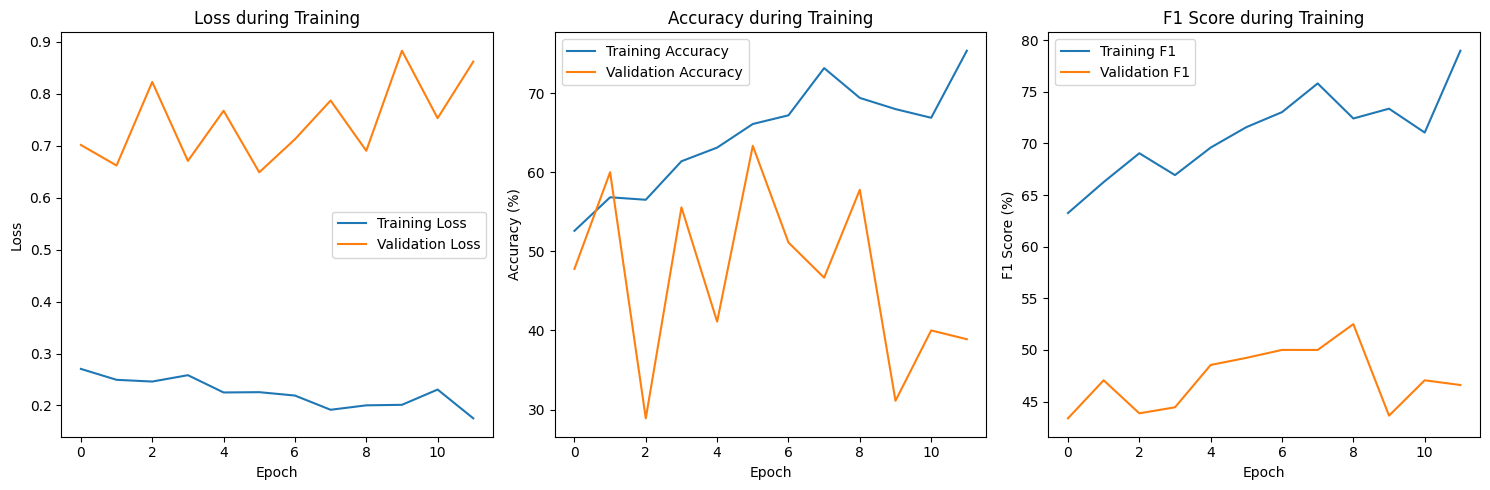

Testing: 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


Test Metrics:
  Accuracy: 55.43%
  F1 Score: 50.60%
  Precision: 36.21%
  Recall: 84.00%
  AUC: 76.39%


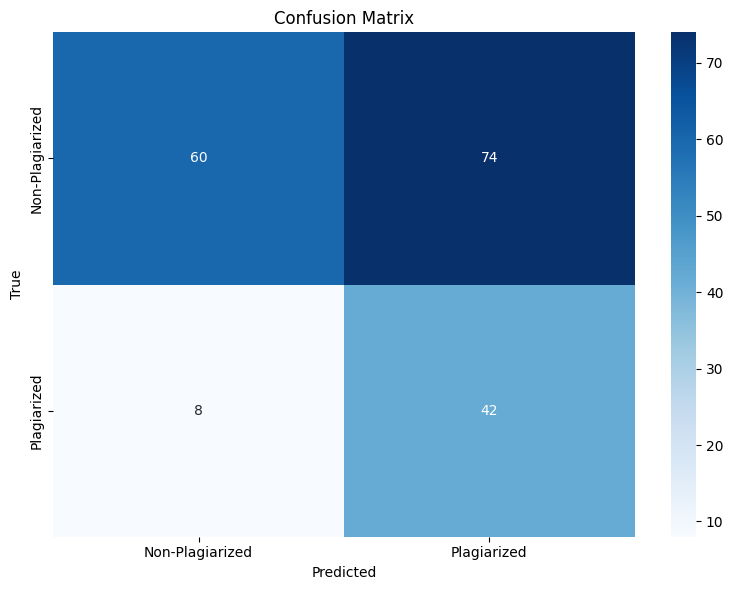

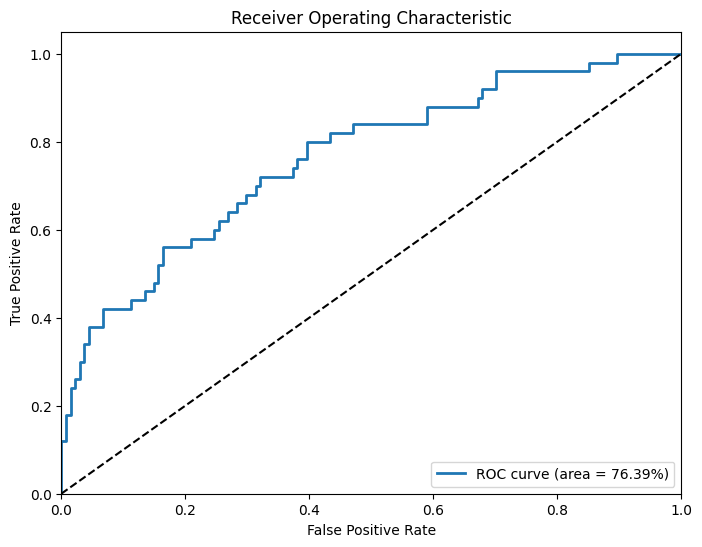

Classification Report:
                 precision    recall  f1-score   support

Non-Plagiarized       0.88      0.45      0.59       134
    Plagiarized       0.36      0.84      0.51        50

       accuracy                           0.55       184
      macro avg       0.62      0.64      0.55       184
   weighted avg       0.74      0.55      0.57       184


Testing different classification thresholds:
  Threshold 0.3: F1 = 0.4292
  Threshold 0.4: F1 = 0.4525
  Threshold 0.5: F1 = 0.5060
  Threshold 0.6: F1 = 0.5440
  Threshold 0.7: F1 = 0.5122


In [7]:
detector.train(train_loader, val_loader, epochs=20)
accuracy = detector.evaluate(test_loader)

In [8]:
optimal_threshold = detector.find_optimal_threshold(val_loader)

Optimal threshold: 0.50 (F1: 0.5250)


Testing: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Test Metrics:
  Accuracy: 55.43%
  F1 Score: 50.60%
  Precision: 36.21%
  Recall: 84.00%
  AUC: 76.39%


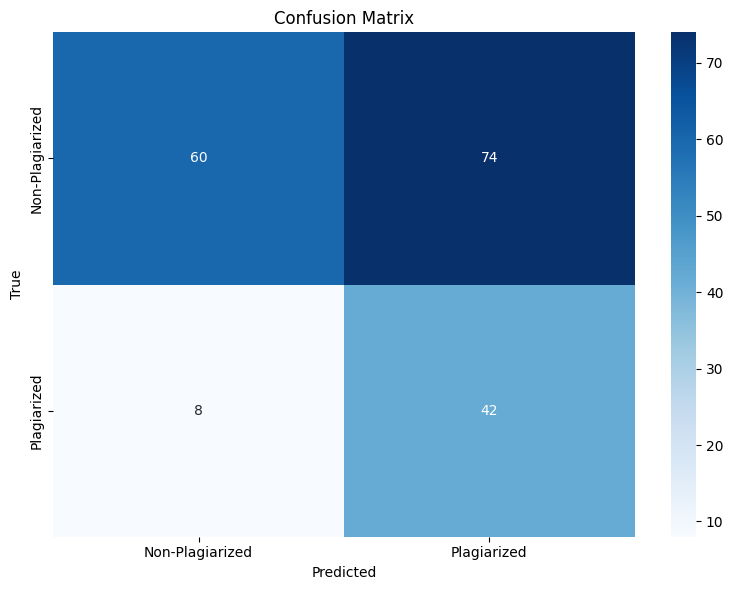

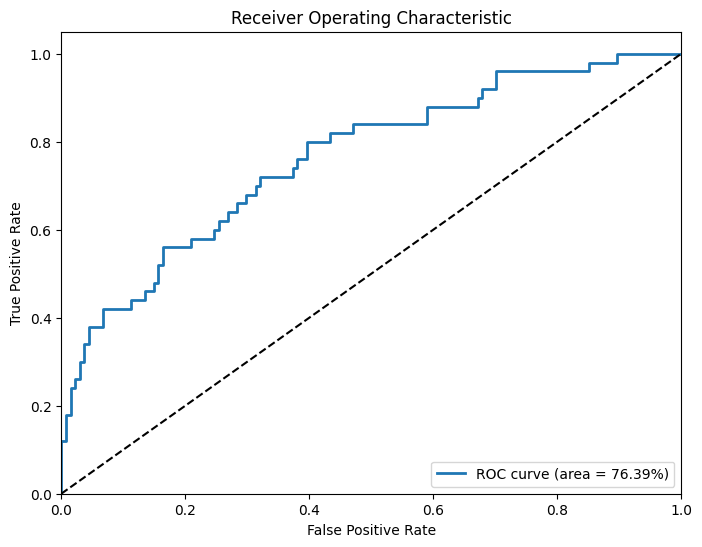

Classification Report:
                 precision    recall  f1-score   support

Non-Plagiarized       0.88      0.45      0.59       134
    Plagiarized       0.36      0.84      0.51        50

       accuracy                           0.55       184
      macro avg       0.62      0.64      0.55       184
   weighted avg       0.74      0.55      0.57       184


Testing different classification thresholds:
  Threshold 0.3: F1 = 0.4292
  Threshold 0.4: F1 = 0.4525
  Threshold 0.5: F1 = 0.5060
  Threshold 0.6: F1 = 0.5440
  Threshold 0.7: F1 = 0.5122


50.602409638554214

In [9]:
detector.evaluate(test_loader)